# Experiments - Time Domain Features
- Create standard time domain (TD) / stat features for the signature data
- Explore the TD features for predictive potential (correlation with target)
- Perform some quick modelling trials

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import fastparquet
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statistics as stats
from statsmodels.graphics.tsaplots import acf
from tqdm import tqdm
from scipy.fftpack import fft

In [2]:
# Training Metadata
metadata_train = pd.read_csv('../metadata_train.csv')
train_signature_count = len(metadata_train)
print('No. of training signatures: ', train_signature_count)

count_undamag = len(metadata_train.loc[(metadata_train['target']==0)])
count_damaged = len(metadata_train.loc[(metadata_train['target']==1)])
print(f'Damaged: {count_damaged} of train_signature_count ({round(100*count_damaged/train_signature_count, 1)}%)')

No. of training signatures:  8712
Damaged: 525 of train_signature_count (6.0%)


In [3]:
phase0_ids = list(metadata_train.loc[(metadata_train['phase']==0)].signal_id)
phase1_ids = list(metadata_train.loc[(metadata_train['phase']==1)].signal_id)
phase2_ids = list(metadata_train.loc[(metadata_train['phase']==2)].signal_id)

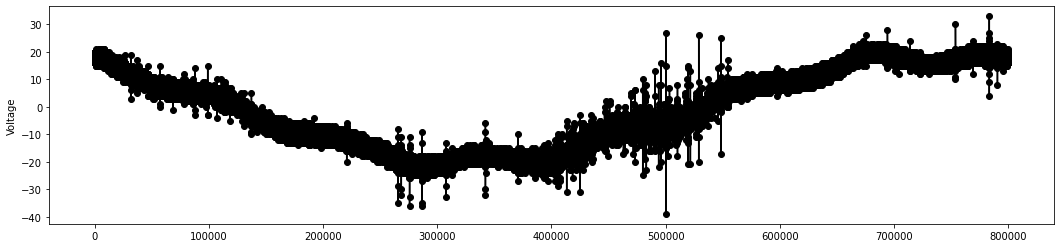

In [4]:
# Quick plot of the first signature 
signals_train = pq.read_table('../data/train.parquet', columns=[str(0)]).to_pandas()
signals_train.iloc[:,0].plot(figsize = (18, 4), color = 'black', marker = 'o')
plt.ylabel("Voltage")
#plt.xlabel("Measurement")
plt.show()

In [8]:
acf(signals_train.iloc[:,0]).mean()

0.9947466008145617

In [5]:
def extract_td_features (dat):
    # Create an empty list to hold calculated features
    features = []
    
    # Create an empty list to hold label names
    labels = []
    
    # Feature dictionary
    feature_dict = {
        't01':'Mean',
        't02':'Mean absolute',
        't03':'Median',
        't04':'Median absolute',
        't05':'Variance',
        't06':'Variance absolute',
        't07':'Max/min',
        't08':'Skewness',
        't09':'Kurtosis',
        't10':'Standard deviation',
        't11':'Bandwidth',
        't12':'Correlation'
        
    }
    globals()['feature_dict'] = feature_dict
    
    # Loop through and create list of label references
    for time_feat in range(1, len(feature_dict)+1, 1):
        labels.append(f't{"{:02d}".format(time_feat)}')
    
    # Calculate features in time domain
    t01 = round(dat.mean(), 4)            # Mean
    t02 = round(abs(dat).mean(), 4)       # Mean absolute
    t03 = round(dat.median(), 4)          # Median
    t04 = round(abs(dat).median(), 4)     # Median absolute
    t05 = round(np.var(dat), 4)           # Variance
    t06 = round(np.var(abs(dat)), 4)      # Variance absolute
    t07 = round(dat.max()/dat.min(), 4)   # Max/min
    t08 = round(dat.skew(), 4)            # Skewness
    t09 = round(dat.kurtosis(), 4)        # Kurtosis
    t10 = round(dat.std(), 4)             # Standard deviation
    band_width = (dat.mean()+dat.std()) - (dat.mean()-dat.std())
    t11 = round(band_width, 4)            # Bandwidth
    t12 = round(acf(dat).mean(), 4)       # Correlation
    
    for feat in range(len(feature_dict)):
        features.append(locals()[f'{list(feature_dict.keys())[feat]}'])
        
    return(features, labels)

In [6]:
# Loop through, load each signature, calculate TD features, create feature dataframe
signature_ids = range(train_signature_count)
#signature_ids = range(3000)
initialise = True
for signature_id in tqdm(signature_ids):
    signals_train = pq.read_table('../data/train.parquet', columns=[str(signature_id)]).to_pandas()
    feature_list, labels = extract_td_features(signals_train.iloc[:, 0])
    if initialise:
        df = pd.DataFrame([feature_list])
        df.columns = labels
        initialise = False
    else:     
        df_add = pd.DataFrame([feature_list])
        df_add.columns = labels
        df = pd.concat([df, df_add], axis=0)
    
df.reset_index(inplace = True, drop = True)    

100%|███████████████████████████████████████| 8712/8712 [23:09<00:00,  6.27it/s]


In [7]:
df['target'] = metadata_train['target'][0:len(df)]

In [8]:
# Filter to phase 0 ids
filtered = list(filter(lambda phase0_ids: phase0_ids <= 2999, phase0_ids))
df = df.iloc[filtered,:]

In [9]:
df_undamaged = df.loc[(df['target']==0)]
df_damaged = df.loc[(df['target']==1)]

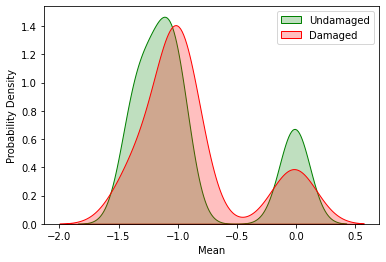

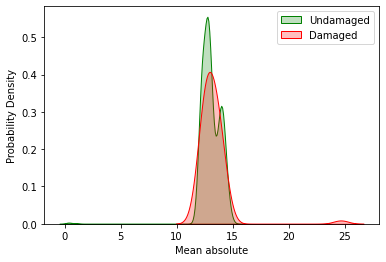

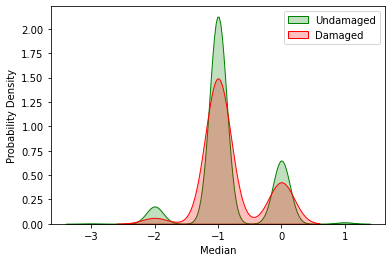

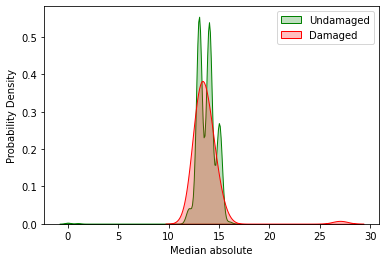

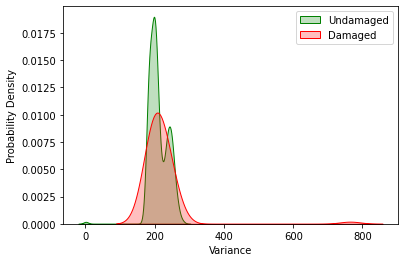

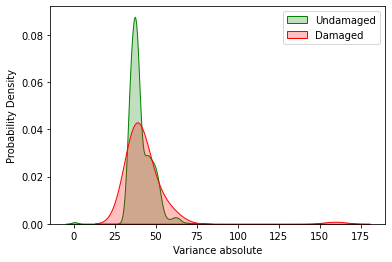

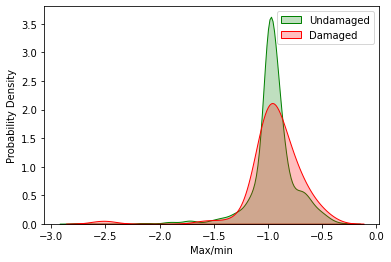

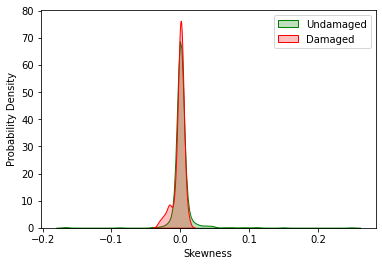

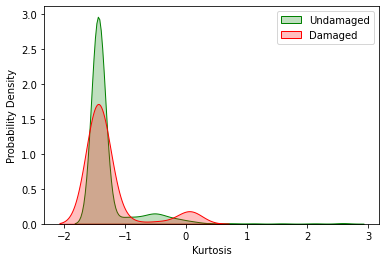

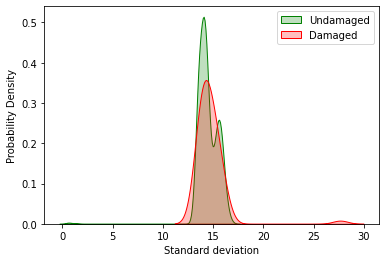

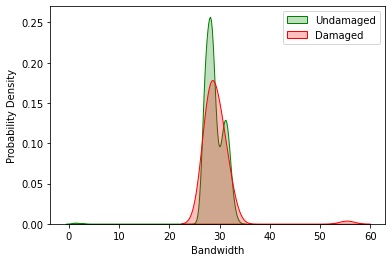

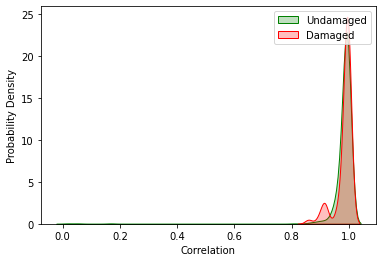

In [12]:
# Plot distribution of each feature for damaged and undamaged signatures
# Inspect for features that may have different distributions between classes
for lab in labels:
    sns.kdeplot(df_undamaged[lab], color='g', shade=True, label='Undamaged') 
    sns.kdeplot(df_damaged[lab], color='r', shade=True, label='Damaged')
     
    plt.xlabel(feature_dict.get(lab))
    plt.ylabel('Probability Density')
    plt.show()

### Preliminary Modelling
- Although from inspection of the above distributions, these features do not look useful.

In [19]:
from sklearn.svm import OneClassSVM
from sklearn import preprocessing

In [20]:
# Standardize the features
data = df.drop(['target'], axis = 1)
scaler = preprocessing.StandardScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data)
data.index = df.index
data['target'] = df['target']

In [21]:
df_undamaged = data.loc[(data['target']==0)]
df_damaged = data.loc[(data['target']==1)]

In [25]:
# Train a one-class SVM 
# nu = contamination 
df_train = df_undamaged.drop(['target'], axis=1)
svm_model =  OneClassSVM(nu = 0.1)
svm_model.fit(pd.DataFrame(df_train))

OneClassSVM(nu=0.1)

In [26]:
# Predict for train set 
preds = pd.Series(svm_model.predict(df_train))
svm_out = pd.DataFrame({'signature':df_train.index, 'Prediction':preds})
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['signature']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly0 = svm_aly

95 out of 935 (10.16%)


In [27]:
# Predict for test set
df_test = df_damaged.drop(['target'], axis=1)
preds = pd.Series(svm_model.predict(df_test))
svm_out = pd.DataFrame({'signature':df_test.index, 'Prediction':preds})
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['signature']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly1 = svm_aly

12 out of 65 (18.46%)
